### Neural Network that hedges an ATM American put option

#### Generate Stock Path

In [99]:
import numpy as np

def generate_stock_paths(S0, r, sigma, T, n_sim, n_steps):
    dt = T / n_steps
    paths = np.zeros((n_sim, n_steps + 1))
    paths[:, 0] = S0
    for i in range(n_steps):
        Z = np.random.normal(size=n_sim)
        paths[:, i+1] = paths[:, i] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return paths

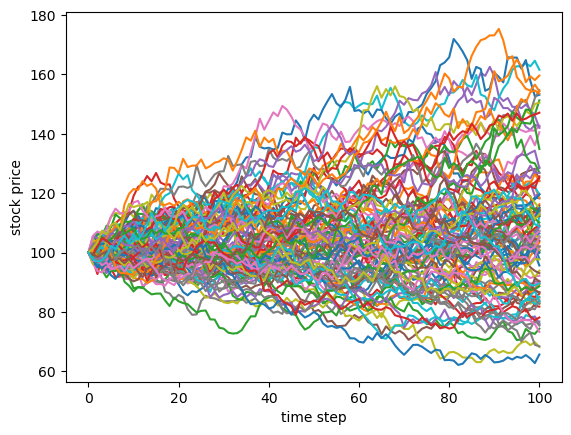

In [100]:
# plot the stock path using generate_stock_paths function
import matplotlib.pyplot as plt
S0 = 100
r = 0.05
sigma = 0.2
T = 1
n_sim = 100
n_steps = 100

paths = generate_stock_paths(S0, r, sigma, T, n_sim, n_steps)
plt.plot(paths.T)
plt.xlabel('time step')
plt.ylabel('stock price')
plt.show()


#### Training the NN Model

In [101]:
import tensorflow as tf
from tqdm import tqdm

# Define the neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='selu', input_shape=(2,)),
    tf.keras.layers.Dense(50, activation='selu'),
    tf.keras.layers.Dense(20, activation='selu'),
    tf.keras.layers.Dense(1)
])
print('Model initialized with random weights !')

# Define the loss function (mean squared error)
def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Define the optimizer (Adam)
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0005)
print('Optimizer initialized !')
print('Start training ...About 2min!')
# Train the neural network using simulated data
n_iterations = 22000
K = 100
for i in tqdm(range(n_iterations)):
    # Generate simulated data
    paths = generate_stock_paths(S0, r, sigma, T, 1, n_steps)
    X = paths[:, :-1]
    # add sigma to the last row of X
    X = np.vstack((X, np.full((1, n_steps), sigma)))
    y = np.zeros((1, n_steps))
    # calculate the optimal delta for each step
    for j in range(n_steps):
        S = paths[:, j]
        V = np.maximum(K - S, 0)  # Payoff of the put option
        if j == n_steps - 1:
            y[:, j] = -V / S  # Optimal hedge ratio at maturity
        else:
            S_next = paths[:, j+1]
            V_next = np.maximum(K - S_next, 0)
            y[:, j] = -(V_next - V) / (S_next - S)  
    # Train the neural network
    # The input of the neural network is the spot price and the volatility
    # The output of the neural network is the hedge ratio
    with tf.GradientTape() as tape:
        y_pred = model(X.T)
        loss = loss_fn(y, y_pred)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))



Model initialized with random weights !
Optimizer initialized !
Start training ...About 2min!


100%|██████████| 22000/22000 [01:38<00:00, 224.29it/s]


#### Test the trained neural network

In [102]:
from scipy.stats import norm
# optimal delta for option using Black-Scholes formula
def optimal_delta(S0, K, r, sigma, T):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(-d1)

Repeat this part can generate different test price path

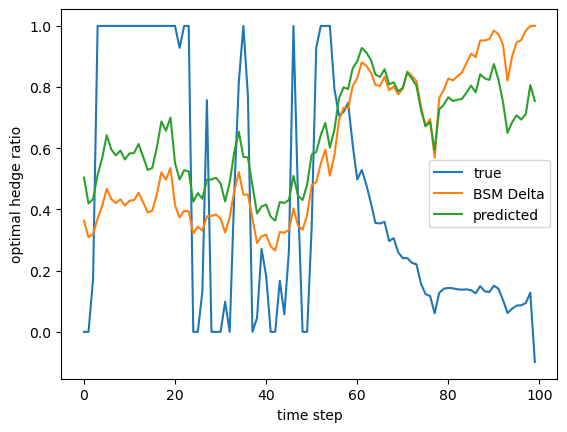

In [103]:
# generate the test data
n_sim_test = 1
paths_test = generate_stock_paths(S0, r, sigma, T, n_sim_test, n_steps)

# use the above trained model to predict the optimal hedge ratio
X_test = paths_test[:, :-1]
y_test = np.zeros((n_sim_test, n_steps))
y_test_BS = np.zeros((n_sim_test, n_steps))
# calculate the true optimal delta for each step using price path
for j in range(n_steps):
        S = paths_test[:, j]
        # calculate the optimal delta with 
        V = np.maximum(K - S, 0)  # Payoff of the put option
        if j == n_steps - 1:
            y_test[:, j] = -V / S  # Optimal hedge ratio at maturity
        else:
            S_next = paths[:, j+1]
            V_next = np.maximum(K - S_next, 0)
            y_test[:, j] = -(V_next - V) / (S_next - S)
# calculate the true optimal delta for each step using BSM formula
for j in range(n_steps):
    S = paths_test[:, j]
    y_test_BS[:, j] = optimal_delta(S, K, r, sigma, T*(1-j/n_steps))
X_test = np.vstack((X_test, np.full((1, n_steps), sigma)))

# predict the optimal hedge ratio using the trained NN model
y_pred_test = model(X_test.T)

# plot the predicted optimal hedge ratio and the true optimal hedge ratio
plt.plot(y_test[0], label='true')
plt.plot(y_test_BS[0], label='BSM Delta')
plt.plot(y_pred_test, label='predicted')
plt.xlabel('time step')
plt.ylabel('optimal hedge ratio')
plt.legend()
plt.show()


The above plot shows the true optimal hedging ratio, BSM hedging ratio and hedging ratio predicted by NN model. During the training process, the input of the neural network is the spot price and the volatility and the output is the hedge ratio. We never use the data from the BSM. However, after training the NN model with the simulation data, we find that the predicted result follows the heding ratio given by BSM, which means NN model finds the pattern that is quite similar to the BSM.